# Exposición al ruido

En este notebook se obtienen tres datasets:
- Población expuesta al ruido en Madrid
- Población expuesta al ruido en los distritos de Madrid
- Centros sociosanitarios y docentes expuestos en Madrid

En primer lugar, se cargan las librerías:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dbfread import DBF
import geopandas as gpd
import datetime
import os
import glob
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

En QGIS se han asignado los receptores con los niveles sonors más cercanos a los edificios. Se obtienen 48 ficheros del proceso, uno por índice y mes. A continuación se define la ruta global hacia los ficheros y se cargan para añadirse todos a una lista:

In [7]:
path_datos = "../Datasets/Exposicion/*"
archivos_distancias = glob.glob(path_datos + '/*.dbf')
archivos_distancias

['../Datasets/Exposicion\\Mes1\\distancias_lday1.dbf',
 '../Datasets/Exposicion\\Mes1\\distancias_lden1.dbf',
 '../Datasets/Exposicion\\Mes1\\distancias_levening1.dbf',
 '../Datasets/Exposicion\\Mes1\\distancias_lnight1.dbf',
 '../Datasets/Exposicion\\Mes10\\distancias_lday10.dbf',
 '../Datasets/Exposicion\\Mes10\\distancias_lden10.dbf',
 '../Datasets/Exposicion\\Mes10\\distancias_levening10.dbf',
 '../Datasets/Exposicion\\Mes10\\distancias_lnight10.dbf',
 '../Datasets/Exposicion\\Mes11\\distancias_lday11.dbf',
 '../Datasets/Exposicion\\Mes11\\distancias_lden11.dbf',
 '../Datasets/Exposicion\\Mes11\\distancias_levening11.dbf',
 '../Datasets/Exposicion\\Mes11\\distancias_lnight11.dbf',
 '../Datasets/Exposicion\\Mes12\\distancias_lday12.dbf',
 '../Datasets/Exposicion\\Mes12\\distancias_lden12.dbf',
 '../Datasets/Exposicion\\Mes12\\distancias_levening12.dbf',
 '../Datasets/Exposicion\\Mes12\\distancias_lnight12.dbf',
 '../Datasets/Exposicion\\Mes2\\distancias_lday2.dbf',
 '../Datasets/Exp

In [13]:
lista_distancias = []
for archivo in archivos_distancias:
    distancias = DBF(archivo, encoding='iso-8859-1')
    distancias = pd.DataFrame(iter(distancias))
    lista_distancias.append(distancias)

## Población expuesta al ruido

Se carga la capa de edificios después de haber eliminado atributos irrelevantes y haber asignado el distrito donde está localizado cada edificio.

In [17]:
building = gpd.read_file('../Datasets buildings/Building_clean2_extended2.shp')

In [18]:
building.rename(columns={'yearConstr':'yearConstruction',
                         'numberOfBu':'numberOfBuildingUnits',
                         'numberOfDw':'numberOfDwellings',
                         'numMaxOfFl':'numMaxOfFloorsAboveGround',
                         'COD_DIS':'cod_distrito',
                         'NOMBRE':'nombre_distrito'}, inplace=True)
building.head()

,gml_id,yearConstruction,localId,currentUse,numberOfBuildingUnits,numberOfDwellings,area,numMaxOfFloorsAboveGround,cod_distrito,nombre_distrito,geometry
0,ES.SDGC.BU. VK4700H,None,VK4700H,None,0,0,0,6,12,Usera,"MULTIPOLYGON (((439573.035 4471080.490, 439572..."
1,ES.SDGC.BU.RA610010000000,1959,RA610010000000,1_residential,1,1,105,1,16,Hortaleza,"POLYGON ((446347.720 4481239.072, 446346.880 4..."
2,ES.SDGC.BU.00006Z8VK4800A,None,00006Z8VK4800A,None,0,0,0,0,6,Tetuán,"POLYGON ((440020.830 4479859.707, 440020.064 4..."
3,ES.SDGC.BU.000200100VK48E,1968,000200100VK48E,2_agriculture,1,0,26,1,8,Fuencarral - El Pardo,"POLYGON ((441657.574 4487050.292, 441658.164 4..."
4,ES.SDGC.BU.000200500VK56E,1995,000200500VK56E,3_industrial,1,0,646,1,18,Villa de Vallecas,"MULTIPOLYGON (((451584.920 4467181.410, 451586..."


Para la exposición al ruido se seleccionan solo los edificios de uso residencial:

In [19]:
# Para la exposición al ruido se seleccionan solo los edificios de uso residencial
building_residential_index = np.where(building['currentUse']=='1_residential')
building_residential = building.loc[building_residential_index]

viviendas_total = building_residential['numberOfDwellings'].sum()
print("Número de viviendas total:", viviendas_total)

Número de viviendas total: 1509046


También se carga el archivo con la población por distrito.

In [20]:
# POBLACIÓN
poblacion = pd.read_excel("../Datasets/C5000123.xlsx", skiprows=range(9), nrows=21, usecols="B,C")
poblacion['Codigo'] = poblacion['Unnamed: 1'].str[:2]
poblacion['Nombre'] = poblacion['Unnamed: 1'].str[4:]
poblacion.rename(columns = {'Unnamed: 2': 'Poblacion'}, inplace=True)

poblacion = poblacion[['Codigo', 'Nombre', 'Poblacion']]
poblacion['Codigo'] = poblacion['Codigo'].astype(int)
poblacion

,Codigo,Nombre,Poblacion
0,1,Centro,139687
1,2,Arganzuela,153304
2,3,Retiro,117918
3,4,Salamanca,145702
4,5,Chamartín,144796
5,6,Tetuán,160002
6,7,Chamberí,138204
7,8,Fuencarral-El Pardo,248443
8,9,Moncloa-Aravaca,121757
9,10,Latina,241672


In [21]:
poblacion_madrid = poblacion['Poblacion'].sum()
print("Población del municipio Madrid:", poblacion_madrid)

Población del municipio Madrid: 3339931


Se calcula el Tamaño Medio del Hogar de Madrid y, luego, para cada distrito. Esta medida se calcula dividiendo la población del territorio censal por el número de viviendas que contiene.

In [22]:
# Tamaño Medio del Hogar de Madrid (TMH)
TMH = poblacion_madrid / viviendas_total
print("Tamaño Medio del Hogar:", TMH)

Tamaño Medio del Hogar: 2.2132731540324153


In [23]:
viviendas_por_distrito = building_residential.groupby(['cod_distrito', 'nombre_distrito'], as_index=False)['numberOfDwellings'].sum()
viviendas_por_distrito['cod_distrito'] = viviendas_por_distrito['cod_distrito'].astype(int)

distritos_df = pd.merge(viviendas_por_distrito, poblacion, left_on='cod_distrito', right_on='Codigo')
distritos_df.drop(['Codigo', 'Nombre'], axis=1, inplace=True)
distritos_df['TMH'] = distritos_df['Poblacion']/distritos_df['numberOfDwellings']
distritos_df

,cod_distrito,nombre_distrito,numberOfDwellings,Poblacion,TMH
0,1,Centro,80930,139687,1.726022
1,10,Latina,108340,241672,2.230681
2,11,Carabanchel,109925,262339,2.386527
3,12,Usera,55685,142746,2.563455
4,13,Puente de Vallecas,98555,241603,2.451454
5,14,Moratalaz,41967,92814,2.211595
6,15,Ciudad Lineal,102532,220345,2.149036
7,16,Hortaleza,85804,198391,2.312142
8,17,Villaverde,61438,159038,2.588593
9,18,Villa de Vallecas,49701,117501,2.364158


Se define la función `poblacion_expuesta_ruido`:

In [24]:
def poblacion_expuesta_ruido(fichero_distancias, fichero_edificios):
    """
    Calcula el ruido al que está expuesto cada edificio y obtiene
    la población expuesta en Madrid y en cada distrito,
    según el índice de ruido y el mes.
    
    Parámetros de entrada:
    - fichero_distancias: fichero con los receptores asignados a los edificios
    - fichero_edificios: fichero con los edificios residenciales
    
    Devuelve:
    - Dataframe con la población expuesta en Madrid
    - Dataframe con la población expuesta en los distritos de Madrid
    """
    # Convertir el nivel Laeq en enteros de 0 a 1 según los rangos
    fichero_distancias['ISOLVL'] = pd.cut(fichero_distancias['LAEQ'], 
                                  bins=[-np.inf, 50, 55, 60, 65, 70, 75, np.inf], 
                                  labels=[0,1,2,3,4,5,6], right=False)
    fichero_distancias['ISOLVL'] = fichero_distancias['ISOLVL'].astype(int)
    
    # Calcular la media de los puntos más cercanos para cada edificio
    distancias_group = np.round(fichero_distancias.groupby(['gml_id'], as_index=False)['ISOLVL'].mean())
    
    # ISOLABEL
    replacements = {0:'< 50', 1:'50-55', 2:'55-60', 3:'60-65', 4:'65-70', 5:'70-75', 6:'> 75'}
    distancias_group['ISOLABEL'] = distancias_group['ISOLVL'].map(replacements)
    
    # Se unen los ficheros
    building_with_noise = pd.merge(fichero_edificios, distancias_group, on='gml_id')

    # Aquí iba lo de residential, pero lo he pasado fuera mejor
    
    # Dataframe población expuesta total
    pop_exposure = building_with_noise.groupby('ISOLABEL', as_index=False)['numberOfDwellings'].sum()
    pop_exposure['poblacion_expuesta'] = np.round(pop_exposure['numberOfDwellings']*TMH).astype(int)
    pop_exposure['% exposure'] = (pop_exposure['numberOfDwellings']/viviendas_total)*100
    
    # Dataframe población expuesta por distrito
    pop_exposure_por_distrito = building_with_noise.groupby(['ISOLABEL','nombre_distrito'], as_index=False)['numberOfDwellings'].sum()
    
    pop_exposure_por_distrito_merge = pd.merge(pop_exposure_por_distrito, distritos_df, on='nombre_distrito')
    
    pop_exposure_por_distrito_merge['poblacion_expuesta'] = np.round(pop_exposure_por_distrito_merge['numberOfDwellings_x']*pop_exposure_por_distrito_merge['TMH']).astype(int)
    pop_exposure_por_distrito_merge['% exposure'] = (pop_exposure_por_distrito_merge['poblacion_expuesta']/pop_exposure_por_distrito_merge['Poblacion'])*100
    
    # este / viviendas_total tendría que ser / por el de viviendas_distrito, que sería mejor poblacion_distrito
    return pop_exposure, pop_exposure_por_distrito_merge

A continuación, se ejecuta la función para cada fichero, índice y mes y se concatenan todos con el objetivo de analizar los dos datasets y visualizarlos en Tableau.

In [25]:
indices = ['Lden', 'Ld', 'Le', 'Ln']*12
meses = ['Enero']*4+['Octubre']*4+['Noviembre']*4+['Diciembre']*4+['Febrero']*4+['Marzo']*4+\
        ['Abril']*4+['Mayo']*4+['Junio']*4+['Julio']*4+['Agosto']*4+['Septiembre']*4

In [29]:
lista_exp_total = []
lista_exp_distritos = []
for distancias, indice, mes in zip(lista_distancias, indices, meses):
    # Se ejecuta la función
    exp_total, exp_distritos = poblacion_expuesta_ruido(distancias, building_residential)
    # Se asigna el índice y el mes
    exp_total[['Indice', 'Mes']] = [indice, mes]
    exp_distritos[['Indice', 'Mes']] = [indice, mes]
    # Se añade a la lista
    lista_exp_total.append(exp_total)
    lista_exp_distritos.append(exp_distritos)

In [30]:
exp_total = pd.concat(lista_exp_total, ignore_index = True)
exp_distritos = pd.concat(lista_exp_distritos, ignore_index = True)

In [31]:
# Exportar dataframes
#exp_total_df = exp_total.to_csv("Datasets/Exposicion/exp_total_all.csv", index=False)
#exp_distritos_df = exp_distritos.to_csv("Datasets/Exposicion/exp_distritos_all.csv", index=False)

In [32]:
# Importar dataframes
#exp_total = pd.read_csv("Datasets/Exposicion/exp_total_all.csv")
#exp_distritos = pd.read_csv("Datasets/Exposicion/exp_distritos_all.csv")

In [6]:
exp_total

,ISOLABEL,numberOfDwellings,poblacion_expuesta,% exposure,Indice,Mes
0,50-55,284700,630119,18.866224,Lden,Enero
1,55-60,218785,484231,14.498233,Lden,Enero
2,60-65,145174,321310,9.620250,Lden,Enero
3,65-70,85281,188750,5.651319,Lden,Enero
4,70-75,29101,64408,1.928437,Lden,Enero
...,...,...,...,...,...,...
331,60-65,51790,114625,3.431970,Ln,Diciembre
332,65-70,13333,29510,0.883538,Ln,Diciembre
333,70-75,1805,3995,0.119612,Ln,Diciembre
334,< 50,1004646,2223556,66.574909,Ln,Diciembre


In [7]:
exp_distritos

,ISOLABEL,nombre_distrito,numberOfDwellings_x,cod_distrito,numberOfDwellings_y,Poblacion,TMH,poblacion_expuesta,% exposure,Indice,Mes
0,50-55,Arganzuela,15861,2,75414,153304,2.032832,32243,21.032067,Lden,Enero
1,55-60,Arganzuela,14871,2,75414,153304,2.032832,30230,19.718990,Lden,Enero
2,60-65,Arganzuela,10282,2,75414,153304,2.032832,20902,13.634347,Lden,Enero
3,65-70,Arganzuela,7662,2,75414,153304,2.032832,15576,10.160205,Lden,Enero
4,70-75,Arganzuela,3127,2,75414,153304,2.032832,6357,4.146663,Lden,Enero
...,...,...,...,...,...,...,...,...,...,...,...
6148,50-55,Villaverde,9164,17,61438,159038,2.588593,23722,14.915932,Ln,Diciembre
6149,55-60,Villaverde,3162,17,61438,159038,2.588593,8185,5.146569,Ln,Diciembre
6150,60-65,Villaverde,774,17,61438,159038,2.588593,2004,1.260076,Ln,Diciembre
6151,65-70,Villaverde,50,17,61438,159038,2.588593,129,0.081113,Ln,Diciembre


#### Análisis

En esta parte únicamente se grafica la distribución de la población de Madrid en 2022 en los diferentes niveles de ruido a los que está expuesta. Para ello se agrupa por nivel e índice de ruido para calcular la media para todos los meses.

In [8]:
exp_por_indices_mean= exp_total.groupby(['ISOLABEL', 'Indice'], as_index=False)['poblacion_expuesta'].mean()
exp_por_indices_mean

,ISOLABEL,Indice,poblacion_expuesta
0,50-55,Ld,6.759388e+05
1,50-55,Lden,6.261443e+05
2,50-55,Le,6.670298e+05
3,50-55,Ln,6.533844e+05
4,55-60,Ld,4.521123e+05
5,55-60,Lden,4.861606e+05
6,55-60,Le,4.586396e+05
7,55-60,Ln,3.095150e+05
8,60-65,Ld,2.530014e+05
9,60-65,Lden,3.259912e+05


In [9]:
exp_total_lden_mean_index = np.where(exp_por_indices_mean['Indice']=='Lden')
exp_total_lden_mean = exp_por_indices_mean.loc[exp_total_lden_mean_index]

exp_total_lday_mean_index = np.where(exp_por_indices_mean['Indice']=='Ld')
exp_total_lday_mean = exp_por_indices_mean.loc[exp_total_lday_mean_index]

exp_total_levening_mean_index = np.where(exp_por_indices_mean['Indice']=='Le')
exp_total_levening_mean = exp_por_indices_mean.loc[exp_total_levening_mean_index]

exp_total_lnight_mean_index = np.where(exp_por_indices_mean['Indice']=='Ln')
exp_total_lnight_mean = exp_por_indices_mean.loc[exp_total_lnight_mean_index]

In [10]:
labels = ['< 50', '50-55', '55-60', '60-65','65-70','70-75','> 75']
order_lden = exp_total_lden_mean.set_index('ISOLABEL').loc[labels]
order_lday = exp_total_lday_mean.set_index('ISOLABEL').loc[labels]
order_levening = exp_total_levening_mean.set_index('ISOLABEL').loc[labels]
order_lnight = exp_total_lnight_mean.set_index('ISOLABEL').loc[labels]

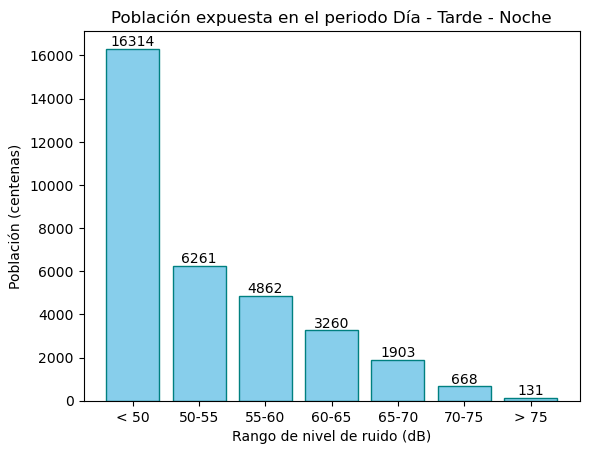

In [11]:
bar = plt.bar(order_lden.index,
              order_lden['poblacion_expuesta']/100,
              color="skyblue", edgecolor="teal")

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

plt.xlabel('Rango de nivel de ruido (dB)')
plt.ylabel('Población (centenas)')
plt.title('Población expuesta en el periodo Día - Tarde - Noche')
plt.savefig('Capturas/poblacion_expuesta_lden.png')
plt.show()

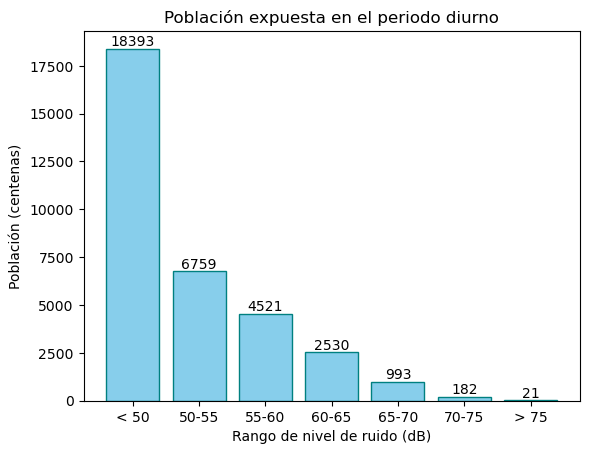

In [12]:
bar = plt.bar(order_lday.index,
              order_lday['poblacion_expuesta']/100,
              color="skyblue", edgecolor="teal")

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

plt.xlabel('Rango de nivel de ruido (dB)')
plt.ylabel('Población (centenas)')
plt.title('Población expuesta en el periodo diurno')
plt.savefig('Capturas/poblacion_expuesta_lday.png')
plt.show()

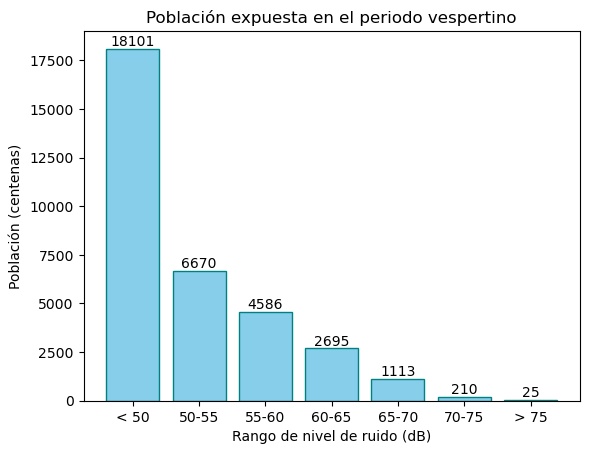

In [13]:
bar = plt.bar(order_levening.index,
              order_levening['poblacion_expuesta']/100,
              color="skyblue", edgecolor="teal")

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

plt.xlabel('Rango de nivel de ruido (dB)')
plt.ylabel('Población (centenas)')
plt.title('Población expuesta en el periodo vespertino')
plt.savefig('Capturas/poblacion_expuesta_levening.png')
plt.show()

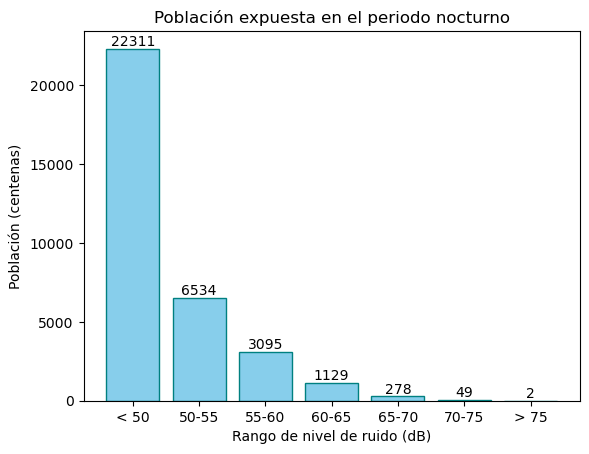

In [14]:
bar = plt.bar(order_lnight.index,
              order_lnight['poblacion_expuesta']/100,
              color="skyblue", edgecolor="teal")

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

plt.xlabel('Rango de nivel de ruido (dB)')
plt.ylabel('Población (centenas)')
plt.title('Población expuesta en el periodo nocturno')
plt.savefig('Capturas/poblacion_expuesta_lnight.png')
plt.show()

## Centros sociosanitarios y docentes expuestos al ruido

El fichero resultante es el que se carga a continuación:

In [15]:
centros_edificios = gpd.read_file('../Datasets/Centros/centros_edificios2.shp')
centros_edificios = centros_edificios[['NOMBRE','TIPO','gml_id']]
centros_edificios2 = centros_edificios.drop(centros_edificios[centros_edificios['TIPO'] == 'CENTROS DE REHABILITACIÓN']
                                            .index).reset_index(drop=True)
centros_edificios.head()

,NOMBRE,TIPO,gml_id
0,"NUEVA EDAD, CENTRO DE DIA",CENTROS DE DÍA,ES.SDGC.BU.4869414VK4746H
1,EL ENCUENTRO,CENTROS DE DÍA,ES.SDGC.BU.4359801VK4745G
2,"SANTA FILIPINA, RESIDENCIA DE PERSONAS MAYORES",CENTROS RESIDENCIALES,ES.SDGC.BU.2802501VK4820D
3,"RSDCIA. SACERDOTAL SAN PEDRO, RESIDENCIA DE PE...",CENTROS RESIDENCIALES,ES.SDGC.BU.0260102VK4706A
4,"NTRA. SRA. DEL PILAR, RESIDENCIA DE PERSONAS M...",CENTROS RESIDENCIALES,ES.SDGC.BU.8374403VK4787C


Con el objetivo de obtener el ruido para cada centro para los doce meses y los cuatro índices de ruido, se define la siguiente función:

In [158]:
def centros_expuestos_ruido(fichero_distancias, fichero_centros, indice, mes):
    """
    Calcula el ruido al que está expuesto cada centro,
    según el índice de ruido y el mes.
    
    Parámetros de entrada:
    - fichero_distancias: fichero con los receptores asignados a los edificios
    - fichero_centros: fichero con los centros sociosanitarios y docentes
    - mes: mes (entero)
    
    Devuelve:
    - Dataframe con los centros expuestos al ruido
    """
    # Se hace aquí la unión para no hacer la media con todos los edificios
    centros_u_edificios = pd.merge(fichero_centros, fichero_distancias, on='gml_id', how='left')

    # Convertir el nivel Laeq en enteros de 0 a 1 según los rangos
    centros_u_edificios['ISOLVL'] = pd.cut(centros_u_edificios['LAEQ'], 
                                      bins=[-np.inf, 50, 55, 60, 65, 70, 75, np.inf], 
                                      labels=[0,1,2,3,4,5,6], right=False)
    centros_u_edificios['ISOLVL'] = centros_u_edificios['ISOLVL'].astype(int)

    # Calcular la media de los puntos más cercanos para cada edificio
    centros_group = np.round(centros_u_edificios.groupby(['gml_id'], as_index=False)['ISOLVL'].mean())
    # ISOLABEL
    replacements = {0:'< 50', 1:'50-55', 2:'55-60', 3:'60-65', 4:'65-70', 5:'70-75', 6:'> 75'}
    centros_group['ISOLABEL'] = centros_group['ISOLVL'].map(replacements)

    # Se unen los ficheros
    centros_with_noise = pd.merge(fichero_centros, centros_group, on='gml_id')
    centros_with_noise.rename(columns={'NOMBRE':'nombre_centro', 'TIPO':'tipo_centro'}, inplace=True)
    centros_with_noise['ISOLVL'] = centros_with_noise['ISOLVL'].astype(int)
    centros_with_noise[['Indice', 'Mes']] = [indice, mes]
    
    return centros_with_noise

A continuación, se ejecuta la función para cada fichero, índice y mes y se concatenan todos con el objetivo de analizar el dataset y visualizarlo en Tableau.

In [124]:
indices = ['Lden', 'Ld', 'Le', 'Ln']*12
meses = ['Enero']*4+['Octubre']*4+['Noviembre']*4+['Diciembre']*4+['Febrero']*4+['Marzo']*4+\
        ['Abril']*4+['Mayo']*4+['Junio']*4+['Julio']*4+['Agosto']*4+['Septiembre']*4

In [159]:
lista_centros_with_noise = []
for distancias, indice, mes in zip(ficheros_distancias, indices, meses):
    centros_with_noise = centros_expuestos_ruido(distancias, centros_edificios2, indice, mes)
    lista_centros_with_noise.append(centros_with_noise)

In [160]:
all_centros_noise = pd.concat(lista_centros_with_noise, ignore_index=True)

In [161]:
all_centros_noise

,nombre_centro,tipo_centro,gml_id,ISOLVL,ISOLABEL,Indice,Mes
0,"NUEVA EDAD, CENTRO DE DIA",CENTROS DE DÍA,ES.SDGC.BU.4869414VK4746H,0,< 50,Lden,Enero
1,EL ENCUENTRO,CENTROS DE DÍA,ES.SDGC.BU.4359801VK4745G,0,< 50,Lden,Enero
2,ESCUELA INFANTIL ESPÍRITU SANTO,CENTROS DOCENTES,ES.SDGC.BU.4359801VK4745G,0,< 50,Lden,Enero
3,"SANTA FILIPINA, RESIDENCIA DE PERSONAS MAYORES",CENTROS RESIDENCIALES,ES.SDGC.BU.2802501VK4820D,0,< 50,Lden,Enero
4,COLEGIO SAGRADO CORAZÓN. CALLE SANTA MAGDALENA...,CENTROS DOCENTES,ES.SDGC.BU.2802501VK4820D,0,< 50,Lden,Enero
...,...,...,...,...,...,...,...
107419,ESCUELA INFANTIL PASO A PASO,CENTROS DOCENTES,ES.SDGC.BU.0224809VK4702C,0,< 50,Ln,Diciembre
107420,ESCUELA INFANTIL PEQUEANDO,CENTROS DOCENTES,ES.SDGC.BU.5055011VK4852E,0,< 50,Ln,Diciembre
107421,ESCUELA INFANTIL REGGIO,CENTROS DOCENTES,ES.SDGC.BU.2941502VK4284B,0,< 50,Ln,Diciembre
107422,ESCUELA MUNICIPAL DE MÚSICA MORATALAZ,CENTROS DOCENTES,ES.SDGC.BU.4338302VK4743G,1,50-55,Ln,Diciembre


Finalmente, se cambia la geometría de puntos por la geometría de los edificios del identificador al que pertenecen y se exporta el conjunto de datos para cargarlo en Tableau.

In [162]:
all_centros_noise2 = pd.merge(all_centros_noise, building[['gml_id','geometry']], on='gml_id', how='left')
all_centros_noise2

,nombre_centro,tipo_centro,gml_id,ISOLVL,ISOLABEL,Indice,Mes,geometry
0,"NUEVA EDAD, CENTRO DE DIA",CENTROS DE DÍA,ES.SDGC.BU.4869414VK4746H,0,< 50,Lden,Enero,"POLYGON ((444745.874 4476793.963, 444746.795 4..."
1,EL ENCUENTRO,CENTROS DE DÍA,ES.SDGC.BU.4359801VK4745G,0,< 50,Lden,Enero,"POLYGON ((444225.585 4475718.555, 444232.135 4..."
2,ESCUELA INFANTIL ESPÍRITU SANTO,CENTROS DOCENTES,ES.SDGC.BU.4359801VK4745G,0,< 50,Lden,Enero,"POLYGON ((444225.585 4475718.555, 444232.135 4..."
3,"SANTA FILIPINA, RESIDENCIA DE PERSONAS MAYORES",CENTROS RESIDENCIALES,ES.SDGC.BU.2802501VK4820D,0,< 50,Lden,Enero,"MULTIPOLYGON (((442587.831 4479984.012, 442590..."
4,COLEGIO SAGRADO CORAZÓN. CALLE SANTA MAGDALENA...,CENTROS DOCENTES,ES.SDGC.BU.2802501VK4820D,0,< 50,Lden,Enero,"MULTIPOLYGON (((442587.831 4479984.012, 442590..."
...,...,...,...,...,...,...,...,...
107419,ESCUELA INFANTIL PASO A PASO,CENTROS DOCENTES,ES.SDGC.BU.0224809VK4702C,0,< 50,Ln,Diciembre,"POLYGON ((440105.105 4472173.791, 440105.834 4..."
107420,ESCUELA INFANTIL PEQUEANDO,CENTROS DOCENTES,ES.SDGC.BU.5055011VK4852E,0,< 50,Ln,Diciembre,"POLYGON ((444928.320 4482399.290, 444928.030 4..."
107421,ESCUELA INFANTIL REGGIO,CENTROS DOCENTES,ES.SDGC.BU.2941502VK4284B,0,< 50,Ln,Diciembre,"MULTIPOLYGON (((442839.975 4483962.835, 442840..."
107422,ESCUELA MUNICIPAL DE MÚSICA MORATALAZ,CENTROS DOCENTES,ES.SDGC.BU.4338302VK4743G,1,50-55,Ln,Diciembre,"POLYGON ((444202.904 4473685.311, 444218.160 4..."


In [163]:
all_centros_noise2_geo = gpd.GeoDataFrame(all_centros_noise2, crs="EPSG:25830", geometry=all_centros_noise2['geometry'])

In [164]:
all_centros_noise2_df = all_centros_noise2_geo.to_file("../Datasets/Centros/Centros_expuestos_ruido.shp", index=False)